In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib notebook
import os
import sys
import pickle
from struct import *
import pandas as pd
from sklearn.model_selection import train_test_split
#import data_utils
from Constants import *
from IPython.display import clear_output
import seaborn as sns
sns.set_style("white")
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Running OG but on one individual P3 (lowest noise) - feature importance

In [3]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import Linear, LSTM, GRU, Conv1d, Conv2d, Dropout, MaxPool2d, BatchNorm1d, BatchNorm2d, CrossEntropyLoss, MSELoss, BCELoss
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax
from torch.nn.utils.weight_norm import weight_norm
from sklearn import preprocessing
import shap
import joblib

In [4]:
from scipy import signal

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")
print(device)

No GPU available.
cpu


## Define functions

In [6]:
def randnorm(n):
    return np.random.normal(loc = 0, scale = 1, size = n).astype('float32')

# Function to get label
def get_labels(batch):
    #print("batch:", Variable(torch.from_numpy(batch['ts']).long()))
    return Variable(torch.from_numpy(batch['ts']).long())

# Function to get input
def get_input(batch):
    return {'x_img': get_variable(Variable(torch.from_numpy(batch['img'])))}
    #return {feat: Variable(torch.from_numpy(batch[feat])) for feat in FEATS}

def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x

def get_numpy(x):
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

def accuracy(ys, ts):
    predictions = torch.max(ys, 1)[1]
    correct_prediction = torch.eq(predictions, ts)
    return torch.mean(correct_prediction.float())

def get_targets(batch):
    #print("target:", Variable(torch.from_numpy(batch['ts']).long()))
    return Variable(torch.FloatTensor(batch['ts']).long())

## Data Utils

In [7]:
from sklearn.preprocessing import LabelEncoder
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    #from sklearn.cross_validation import StratifiedShuffleSplit
    # cross_validation -> now called: model_selection
    # https://stackoverflow.com/questions/30667525/importerror-no-module-named-sklearn-cross-validation
    from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold


def onehot(t, num_classes):
    out = np.zeros((t.shape[0], num_classes))
    for row, col in enumerate(t):
        out[int(row), int(col)] = 1
    return out


class load_data():
    # input are pandas dataframes
    def __init__(self, x_train, y_train, x_test, y_test):
        self.image_shape = IMAGE_SHAPE[:2]
        self._load(x_train, y_train, x_test, y_test)
        
    def _load(self, x_train, y_train, x_test, y_test):
        #print("Loading training data")
        train_data = self._make_dataset(x_train, y_train)
        #print("Loading test data")
        test_data = self._make_dataset(x_test, y_test)        
        # need to reformat the train for validation split reasons in the batch_generator
        self.train = self._format_dataset(train_data)
        self.test = self._format_dataset(test_data)
        
        
    def _make_dataset(self, df, y=None):
        seq_length=WINDOW
        # make dataset
        data = dict()

        for i, dat in enumerate(df.iterrows()):
            index, row = dat
            sample = dict()
            features = row.values
            #for j in range(len(FEATS)):
            #    sample[FEATS[j]] = features[WINDOW*j:WINDOW*(j+1)]
            image = np.reshape(features, self.image_shape)
            image = np.expand_dims(image, axis=2)
            sample['img'] = image
            sample['t'] = np.asarray(y.loc[index], dtype='int32')
            data[index] = sample
            #if i % 200 == 0:
                #print("\t%d of %d" % (i, len(df)))
        
        return data

    def _format_dataset(self, d):
        # making arrays with all data in, is nessesary when doing validation split
        data = dict()
        value = list(d.values())[0]
        img_tot_shp = tuple([len(d)] + list(value['img'].shape))
        data['img'] = np.zeros(img_tot_shp, dtype='float32')
        #feature_tot_shp = (len(d), WINDOW)
        #for feat in FEATS:
        #    data[feat] = np.zeros(feature_tot_shp, dtype='float32')
        data['ts'] = np.zeros((len(d),), dtype='int32')
        data['ids'] = np.zeros((len(d),), dtype='int32')
        for i, pair in enumerate(d.items()):
            key, value = pair
            #for feat in FEATS:
            #    data[feat][i] = value[feat]
            data['img'][i] = value['img']
            data['ts'][i] = value['t']
            data['ids'][i] = key
        
        return data

    
class batch_generator():
    def __init__(self, data, batch_size=BATCH_SIZE, num_classes=NUM_CLASSES,
                 num_iterations=5e3, num_features=WINDOW, seed=42, val_size=0.1):
        self._train = data.train
        self._test = data.test
        self._batch_size = batch_size
        self._num_classes = num_classes
        self._num_iterations = num_iterations
        self._num_features = num_features
        # get image size
        value = self._train['img'][0]
        self._image_shape = list(value.shape)
        self._seed = seed
        self._val_size = val_size
        self._valid_split()
        
    def _valid_split(self):
        # Updated to use: model_selection
        sss = StratifiedShuffleSplit(
            n_splits=1,
            test_size=self._val_size,
            random_state=self._seed
        ).split(
            np.zeros(self._train['ts'].shape),
            self._train['ts']
        )
        self._idcs_train, self._idcs_valid = next(iter(sss))
        
    def _shuffle_train(self):
        np.random.shuffle(self._idcs_train)

    def _batch_init(self, purpose):
        assert purpose in ['train', 'valid', 'test']
        batch_holder = dict()
        #for feat in FEATS:
        #    batch_holder[feat] = np.zeros((self._batch_size, self._num_features), dtype='float32')
        batch_holder['img'] = np.zeros(tuple([self._batch_size] + list(self._image_shape)), dtype='float32')
        batch_holder['ts'] = np.zeros((self._batch_size, self._num_classes), dtype='float32')          
        batch_holder['ids'] = []
        return batch_holder

    def gen_valid(self):
        batch = self._batch_init(purpose='valid')
        i = 0
        for idx in self._idcs_valid:
            #for feat in FEATS:
            #    batch[feat][i] = self._train[feat][idx]
            batch['img'][i] = self._train['img'][idx]
            batch['ts'][i] = onehot(np.asarray([self._train['ts'][idx]], dtype='float32'), self._num_classes)
            i += 1
            if i >= self._batch_size:
                yield batch, i
                batch = self._batch_init(purpose='valid')
                i = 0
        if i != 0:
            batch['ts'] = onehot(np.asarray([self._train['ts'][idx]], dtype='float32'), self._num_classes)
            #for feat in FEATS:
            #    batch[feat] = batch[feat][:i]
            batch['img'] = batch['img'][:i]
            yield batch, i

    def gen_test(self):
        batch = self._batch_init(purpose='test')
        i = 0
        for idx in range(len(self._test['ids'])):
            #for feat in FEATS:
            #    batch[feat][i] = self._test[feat][idx]
            batch['img'][i] = self._test['img'][idx]
            batch['ts'][i] = onehot(np.asarray([self._test['ts'][idx]], dtype='float32'), self._num_classes)
            batch['ids'].append(self._test['ids'][idx])
            i += 1
            if i >= self._batch_size:
                yield batch, i
                batch = self._batch_init(purpose='test')
                i = 0
        if i != 0:
            yield batch, i     

    def gen_train(self):
        batch = self._batch_init(purpose='train')
        iteration = 0
        i = 0
        while iteration < self._num_iterations:
            # shuffling all batches
            self._shuffle_train()
            for idx in self._idcs_train:
                # extract data from dict
                #for feat in FEATS:
                #    batch[feat][i] = self._train[feat][idx]
                batch['img'][i] = self._train['img'][idx]
                batch['ts'][i] = onehot(np.asarray([self._train['ts'][idx]], dtype='float32'), self._num_classes)
                i += 1
                if i >= self._batch_size:
                    yield batch
                    batch = self._batch_init(purpose='train')
                    i = 0
                    iteration += 1
#                     if iteration >= self._num_iterations:
#                         break
                    

## Load the data
When predicting user AMPS error, each model should be specific to the individual.
The device and participant are set in Constants.py.

In [8]:
import pandas as pd
x = pd.read_csv('/data/Isabella/thesis_spring2022/NN/models/errors/error_totals.csv')
y = pd.read_csv('/data/AMPs/tagging_data_second-round.csv')
print(sum(x.num_errors),len(y))

1260 1427


In [9]:
# Upload the error data
#errors = pd.read_csv('/home/s202576/thesis_spring2022/NN/data_prep/tagged_errors.csv', index_col=[0])
errors_ = pd.read_csv('/home/s202576/thesis_spring2022/NN/data_prep/error-tags_full.csv', index_col=[0])

errors_.loc[:, 'subID':'Track'] = errors_.loc[:, 'subID':'Track'].astype(str)
#errors.loc[:, 'Timestamp':'value5b'] = errors.loc[:, 'Timestamp':'value5b'].astype(float)
errors_.loc[:, 'HMD'] = errors_.loc[:, 'HMD'].astype(str)
errors_.loc[:, 'offset'] = errors_.loc[:, 'offset'].astype(bool)
#errors.loc[:, 'Timestamp_adjusted'] = errors.loc[:, 'Timestamp_adjusted'].astype(float)

# Determine whether the type of error is a motor error (and not a process error)
errors_['motor_error'] = False
for idx, row in errors_.iterrows():
    if row.error_type_value1=='1' or row.error_type_value2=='1' or row.error_type_value3=='1' or row.error_type_value4=='1' or row.error_type_value5=='1':
        errors_.loc[idx, 'motor_error'] = True
    
errors_ = errors_[errors_.HMD==DEVICE]
errors_ = errors_[errors_.motor_error==True]

errors_.reset_index(drop=True, inplace=True)

assert all(errors_['offset'] == True), "The timestamps of tagged errors have not been adjusted."

In [10]:
errors_.head()

,subID,task,Video,Track,Timestamp,errors_in_frame,time_to_prev_error,time_to_next_error,value1,error_type_value1,...,error_subtype_value4,value4b,value5,error_type_value5,error_subtype_value5,value5b,HMD,offset,Timestamp_adjusted,motor_error
0,P5,cereal,P5_cereal_2_merged_varjo.mp4,error frame,7.84,2,,-4,31,2,...,,,,,,,varjo,True,8.403196,True
1,P5,cereal,P5_cereal_2_merged_varjo.mp4,error frame,11.84,1,4,-7.52,13,1,...,,,,,,,varjo,True,12.403196,True
2,P5,cereal,P5_cereal_2_merged_varjo.mp4,error frame,19.36,2,7.52,-5.64,13,1,...,,,,,,,varjo,True,19.923196,True
3,P5,cereal,P5_cereal_2_merged_varjo.mp4,error frame,25.00,2,5.64,-7.36,6,1,...,,,,,,,varjo,True,25.563196,True
4,P5,cereal,P5_cereal_2_merged_varjo.mp4,error frame,32.36,1,7.36,-1.12,1,1,...,,,,,,,varjo,True,32.923196,True


In [11]:
# Read in the output data from event detection
sequences = pd.read_csv('/data/Isabella/thesis_spring2022/event_detect_out_final/all_sequences_varjo.csv')

#sequences.loc[(sequences.event=='sac')&(sequences.has_blink==1)] = 'blink'

# Filter data for error prediction
events_df = sequences[sequences.HMD==DEVICE]

In [12]:
# remove all loss, noise, and other events
events_df.drop(events_df.loc[(events_df.event=='noise')&(events_df.event=='loss')&(events_df.event=='other')].index.tolist(),inplace=True)

# Reset indices
events_df.reset_index(drop=True, inplace=True)

In [13]:
# Encode event as index using EVENT_DICT as defined in Constants.py
events_df['event'] = np.where(events_df.event=='fix', EVENT_DICT['fix'], np.where(events_df.event=='sac',EVENT_DICT['sac'],np.where(events_df.event=='smp',EVENT_DICT['smp'],np.where(events_df.event=='blink',EVENT_DICT['blink'],EVENT_DICT['other']))))

In [14]:
events_df = events_df.loc[:,'HMD':]
events_df.head()

,HMD,rate,eye,task,subID,VL,event,start_i,end_i,start_s,...,calculus_error,carpenter_error,P_nonfix,P_fix,P_ff,P_smp,P_sac,P_blink,has_blink,UID
0,varjo,200,right,cereal,P19,CVL,2,0,25,1.081565,...,0.366132,1.527210,0.534494,0.465506,5.470863e-11,0.465506,0.384207,0.150287,0,varjoP19cerealright
1,varjo,200,right,cereal,P19,CVL,0,26,49,1.211610,...,0.230767,2.684010,0.059622,0.940378,8.531830e-01,0.087195,0.057516,0.002106,0,varjoP19cerealright
2,varjo,200,right,cereal,P19,CVL,1,50,56,1.326648,...,0.732365,0.474248,0.728794,0.271206,2.022088e-01,0.068997,0.000396,0.728398,0,varjoP19cerealright
3,varjo,200,right,cereal,P19,CVL,4,57,59,1.361658,...,NaN,NaN,0.667140,0.332860,3.218246e-01,0.011035,0.000000,0.000000,0,varjoP19cerealright
4,varjo,200,right,cereal,P19,CVL,0,60,205,1.381670,...,0.913183,24.923594,NaN,NaN,NaN,NaN,NaN,NaN,0,varjoP19cerealright


In [15]:
events_df.subID.unique()

array(['P19', 'P24', 'P6', 'P5', 'P21', 'P9', 'P14', 'P15', 'P13', 'P18',
       'P25', 'P22', 'P23', 'P3', 'P2', 'P8'], dtype=object)

In [16]:
# upload the experiment start and end times
offsets = pd.read_csv('/home/s202576/thesis_spring2022/NN/data_prep/offsets.csv', index_col=[0])

In [17]:
offsets.head()

,HMD,subID,task,exper_start(s),exper_end(s)
0,varjo,P14,cereal,2.262060,175.435060
1,varjo,P14,sandwich,-0.044110,502.057489
2,varjo,P23,cereal,0.794094,189.215660
3,varjo,P23,sandwich,1.659792,948.839357
4,varjo,P19,cereal,2.963828,137.798528


In [18]:
# upload the differences between gaze data and videos
gaze_dur_diff = pd.read_csv('/home/s202576/thesis_spring2022/NN/data_prep/gaze_dur_diff.csv', index_col=[0])
gaze_dur_diff.head()

,HMD,task,subID,type,lum_path,dur(s),min_lum_roc,min_lum_frame,min_lum_time(s),data_dur(s),diff(s)
0,varjo,cereal,P14,full,/data/AMPs/second-round/avg-lum-per-frame/P14_...,172.733166,-0.621721,206.0,6.866660,172.757628,-0.024462
2,varjo,cereal,P23,full,/data/AMPs/second-round/avg-lum-per-frame/P23_...,188.033152,-0.459796,201.0,6.699994,188.056043,-0.022891
4,varjo,cereal,P19,full,/data/AMPs/second-round/avg-lum-per-frame/P19_...,137.433200,-0.376091,174.0,5.799994,137.429682,0.003519
6,varjo,cereal,P2,full,/data/AMPs/second-round/avg-lum-per-frame/P2_c...,121.699882,-0.389706,193.0,6.433327,121.715036,-0.015154
8,varjo,cereal,P9,full,/data/AMPs/second-round/avg-lum-per-frame/P9_c...,123.899880,-0.535024,210.0,6.999993,123.907213,-0.007332


## The model

In [19]:
# Keep track of features to output layer
features_cat_size = 96#192 #WIDTH*PADDING[1]

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_1 = Conv2d(in_channels = CHANNELS,
                             out_channels = OUT_CHANNELS[0],
                             kernel_size = KERNEL_SIZE,
                             stride = STRIDE,
                             padding = PADDING)

        self.conv_2 = Conv2d(in_channels = OUT_CHANNELS[0],
                             out_channels = OUT_CHANNELS[1],
                             kernel_size = KERNEL_SIZE[1],
                             stride = STRIDE,
                             padding = PADDING)
        
        self.lin_1 = Linear(in_features = 896,
                           out_features = 96,
                           bias=False)
        
        # Output linear layer
        self.l_out = Linear(in_features = features_cat_size,
                            out_features = NUM_CLASSES,
                            bias = False)

        # Functions to help generalize the model
        self.batchnorm2d_1 = BatchNorm2d(CHANNELS)
        self.batchnorm2d_2 = BatchNorm2d(OUT_CHANNELS[0])
        #self.maxp = MaxPool2d(kernel_size = (1,OUT_CHANNELS[0]), stride = (1,5))
        self.dropout = Dropout(p = 0.2)
        self.batchnorm2d_3 = BatchNorm2d(OUT_CHANNELS[1])
        
    def forward(self, x_img):
        out = {}
        features = []
        batch_size = x_img.shape[0]
        
        ## Convolutional layer ##
        # - Change dimensions to fit the convolutional layer 
        # - Apply Conv2d
        # - Use an activation function
        x_img = x_img.permute(0, 3, 1, 2)  # input in the shape (batch_size, in_channels, height, width)
        x_img = self.conv_1(x_img)
        x_img = relu(x_img)
        #x_img = self.maxp(x_img)
        x_img = self.batchnorm2d_2(x_img)
        x_img = self.dropout(x_img)
        
        #x_img = x_img.permute(0, 2, 1, 3)
        x_img = self.conv_2(x_img)
        x_img = relu(x_img)
        x_img = self.batchnorm2d_3(x_img)
        x_img = self.dropout(x_img)
        
        #x_img = self.batchnorm2d_3(x_img)
        features_img = x_img.reshape(batch_size, -1)
        
        # Linear layer
        features_img = self.lin_1(features_img)
        
        ## Output layer ##
        out['out'] = softmax(self.l_out(features_img))
        
        return out


## Collect the data into "images"
The model will be trained on the pattern of eye movements which are marked as error. The goal is to be able to detect likely errors in the full dataset. A separate model is trained for each participant.

In [20]:
events_df.subID.unique()

array(['P19', 'P24', 'P6', 'P5', 'P21', 'P9', 'P14', 'P15', 'P13', 'P18',
       'P25', 'P22', 'P23', 'P3', 'P2', 'P8'], dtype=object)

In [21]:
# Create datasets of samples of events, with sliding window

if SUBJECT == 'CVL' or SUBJECT == 'PVL':
    events_df = events_df[events_df.VL==SUBJECT]
else:
    events_df = events_df[events_df.subID==SUBJECT]

    
FI = pd.DataFrame({})
l = ['none']+FEATS+['all']
    
for F in l:
    
    labels = []
    features = []
    
    for subID in events_df.subID.unique():

        temp_ = events_df[events_df.subID == subID]
        temp_.reset_index(drop=True, inplace=True)

        errors = errors_[errors_.subID==subID]
        errors.reset_index(drop=True, inplace=True)

        for eye in temp_.eye.unique():

            success = []

            for task in temp_.task.unique().tolist():

                # Only include data for which there are labelled errors
                try:
                    exper_start = offsets.loc[(offsets.subID==subID) & (offsets.task==task), 'exper_start(s)'].values[0]
                    exper_end = offsets.loc[(offsets.subID==subID) & (offsets.task==task), 'exper_end(s)'].values[0]
                    dur_diff = np.abs(gaze_dur_diff.loc[(gaze_dur_diff.subID==subID) & (gaze_dur_diff.task==task), 'diff(s)']).values[0]
                    success.append(task)
                except:
                    continue

                temp = temp_.loc[(temp_.task == task) & (temp_.eye == eye)]
                temp.reset_index(drop=True, inplace=True)

                error_t = errors[errors.task==task].Timestamp_adjusted.to_numpy()

                if len(error_t) == 0:
                    continue



                for i in range(0, len(temp)-WINDOW, STEP):
                    # Only add the sequence if it falls within the experiment time
                    if temp.loc[i, 'start_s'] < exper_start or temp.loc[i+WINDOW-1, 'end_s'] > exper_end:
                        continue

                    subID = temp.loc[i,'subID']
                    VL = temp.loc[i,'VL']

                    # Only label as error if all events fall within 2 seconds prior of error timestamp 
                    #  and 5 seconds after errors timestamp -/+ the absolute value of duration difference between
                    #  gaze video and gaze data abs(gaze_dur_diff).
                    start_seq = temp.loc[i,'start_s']-3-dur_diff
                    end_seq = temp.loc[i+WINDOW-1,'end_s']+2+dur_diff
                    has_error = [(e >= start_seq and e <= end_seq) for e in error_t]
                    error = np.any(has_error)

                    if len(error_t) == 0 and CLASSIFIER == 'error':
                        continue

                    # Event features to include
                    event = np.nan_to_num(temp.loc[i:i+WINDOW-1, 'event'].to_numpy())
                    duration = np.nan_to_num(temp.loc[i:i+WINDOW-1, 'duration'].to_numpy())
                    amplitude = np.nan_to_num(temp.loc[i:i+WINDOW-1, 'amplitude'].to_numpy())
                    dispersion = np.nan_to_num(temp.loc[i:i+WINDOW-1, 'duration'].to_numpy())
                    avg_iss = np.nan_to_num(temp.loc[i:i+WINDOW-1, 'avg_iss'].to_numpy())
                    max_iss = np.nan_to_num(temp.loc[i:i+WINDOW-1, 'max_iss'].to_numpy())
                    carpenter_error = np.nan_to_num(temp.loc[i:i+WINDOW-1, 'carpenter_error'].to_numpy())
                    calculus_error = np.nan_to_num(temp.loc[i:i+WINDOW-1, 'calculus_error'].to_numpy())
                    has_blink = np.nan_to_num(temp.loc[i:i+WINDOW-1, 'has_blink'].to_numpy())
                    random = np.random.normal(size=(1,WINDOW)).reshape((WINDOW,))

                    # Sequence features to include (same across each event)

                    # number of blinks that occur during the sequence
                    num_blinks = [event.tolist().count(EVENT_DICT['blink'] + sum(has_blink))/WINDOW]*WINDOW # blink ratio

                    # number of errors that happen within time range
                    #num_errors = [sum(has_error)]*WINDOW

                    # time from previous error to beginning of sequence
                    prev_ = np.where(error_t < start_seq)[0]
                    if len(prev_) > 0:
                        prev_error = [start_seq-error_t[max(prev_)]]*WINDOW
                    else:
                        prev_error = [0.0]*WINDOW

                    # time to next error from end of sequence
                    next_ = np.where(error_t > end_seq)[0]
                    if len(next_) > 0:
                        next_error = [error_t[min(next_)]-end_seq]*WINDOW
                    else:
                        next_error = [0.0]*WINDOW

                    # total duration of sequence
                    total_dur = [temp.loc[i+WINDOW-1,'end_s']-temp.loc[i,'start_s']]*WINDOW

                    # zero the non-relevant features depending on event (all blink feats)
                    fixi = np.where(event==EVENT_DICT['fix'])[0]
                    saci = np.where(event==EVENT_DICT['sac'])[0]
                    smpi = np.where(event==EVENT_DICT['smp'])[0]
                    blinki = np.where(event==EVENT_DICT['blink'])[0]
                    duration[blinki], amplitude[blinki], dispersion[blinki], avg_iss[blinki], max_iss[blinki], carpenter_error[blinki], calculus_error[blinki] = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

                    # feature importance
                    if F == 'event':
                        event = random
                    elif F == 'duration':
                        duration = random
                    elif F == 'amplitude':
                        amplitude = random
                    elif F == 'dispersion':
                        dispersion = random
                    elif F == 'avg_iss':
                        avg_iss = random
                    elif F == 'max_iss':
                        max_iss = random
                    elif F == 'carpenter_error':
                        carpenter_error = random
                    elif F == 'calculus_error':
                        calculus_error = random
                    elif F == 'num_blinks':
                        num_blinks = random
                    elif F == 'prev_error':
                        prev_error = random
                    elif F == 'next_error':
                        next_error = random
                    elif F == 'total_dur':
                        total_dur = random
                    elif F == 'all':
                        event = np.random.normal(size=(1,WINDOW)).reshape((WINDOW,))
                        duration = np.random.normal(size=(1,WINDOW)).reshape((WINDOW,))
                        amplitude = np.random.normal(size=(1,WINDOW)).reshape((WINDOW,))
                        dispersion = np.random.normal(size=(1,WINDOW)).reshape((WINDOW,))
                        avg_iss = np.random.normal(size=(1,WINDOW)).reshape((WINDOW,))
                        max_iss = np.random.normal(size=(1,WINDOW)).reshape((WINDOW,))
                        carpenter_error = np.random.normal(size=(1,WINDOW)).reshape((WINDOW,))
                        calculus_error = np.random.normal(size=(1,WINDOW)).reshape((WINDOW,))
                        num_blinks = np.random.normal(size=(1,WINDOW)).reshape((WINDOW,))
                        prev_error = np.random.normal(size=(1,WINDOW)).reshape((WINDOW,))
                        next_error = np.random.normal(size=(1,WINDOW)).reshape((WINDOW,))
                        total_dur = np.random.normal(size=(1,WINDOW)).reshape((WINDOW,))

                    # labels of shape 1 x 4
                    labels.append([subID, VL, task, error])
                    # features of shape num_feats x window_size
                    features.append(np.array([event,
                                              duration,
                                              amplitude,
                                              dispersion,
                                              avg_iss,
                                              max_iss,
                                              carpenter_error,
                                              calculus_error,
                                              num_blinks,
                                              prev_error,
                                              next_error,
                                              total_dur
                                             ]).flatten())
                    
    avg_tot_dur = sum([features[i][-1] for i in range(len(features))])/len(features)


    ## CREATE DATA
    feature_headers = []
    for feat in FEATS:
        feature_headers += [str(feat+str(i+1)) for i in range(WINDOW)]
    label_headers = LABELS

    # Combine into one dataframe
    Y = pd.DataFrame(data=np.array(labels), columns=label_headers)
    X = pd.DataFrame(data=np.array(features), columns=feature_headers)

    df = pd.concat([Y,X],axis=1)


    ## SPLIT INTO TRAIN AND TEST
    # Convert error column to boolean (1=True, 0=False)
    df['error'] = np.where(df.error=='True',1,0)

    # ensure that there are same proportion of errors in train and test
    positive = df[df[CLASSIFIER]==True]
    negative = df[df[CLASSIFIER]==False]

    X_positive = positive.iloc[:,len(LABELS):]
    X_negative = negative.iloc[:,len(LABELS):]
    Y_positive = positive.loc[:,CLASSIFIER]
    Y_negative = negative.loc[:,CLASSIFIER]

    x_train1, x_test1, y_train1, y_test1 = train_test_split(X_positive, Y_positive, test_size = 0.2, random_state = 42, shuffle = True)
    x_train2, x_test2, y_train2, y_test2 = train_test_split(X_negative, Y_negative, test_size = 0.2, random_state = 42, shuffle = True)

    x_train = pd.concat([x_train1, x_train2], axis=0)
    x_test = pd.concat([x_test1, x_test2], axis=0)
    y_train = pd.concat([y_train1, y_train2], axis=0)
    y_test = pd.concat([y_test1, y_test2], axis=0)

    ## LOAD INTO DATA LOADER
    data = load_data(x_train, y_train, x_test, y_test)

    ## CREATE BATCHES
    dummy_batch_gen = batch_generator(data, batch_size=BATCH_SIZE, num_classes=NUM_CLASSES, num_iterations=5e3, seed=42)
    train_batch = next(dummy_batch_gen.gen_train())
    valid_batch, i = next(dummy_batch_gen.gen_valid())
    test_batch, i = next(dummy_batch_gen.gen_test())

    ## BUILD THE MODEL
    net = Net()
    if use_cuda:
        net.cuda()

    ## BUILD THE COST FUNCTION
    criterion = CrossEntropyLoss()

    # weight_decay is equal to L2 regularization
    optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay = WEIGHT_DECAY)

    ## TRAIN THE MODEL
    # Setup settings for training 
    VALIDATION_SIZE = 0.1 # 0.1 is ~ 100 samples for validation
    log_every = 200
    eval_every = 100

    # Generate batches
    #batch_gen = data_utils.batch_generator(data,
    batch_gen = batch_generator(data,
                               batch_size=BATCH_SIZE,
                               num_classes=NUM_CLASSES,
                               num_iterations=MAX_ITER,
                               seed=42,
                               val_size=VALIDATION_SIZE)

    # Initialize lists for training and validation
    train_iter = []
    train_loss, train_accs = [], []
    valid_iter = []
    valid_loss, valid_accs = [], []

    avg_loss = []
    avg_accs = []

    # Train network
    net.train()
    for i, batch_train in enumerate(batch_gen.gen_train()):
        if i % eval_every == 0:
            # Do the validation
            net.eval()
            val_losses, val_accs, val_lengths = 0, 0, 0
            for batch_valid, num in batch_gen.gen_valid():
                if num != BATCH_SIZE:
                    continue
                output = net(**get_input(batch_valid))
                labels_argmax = torch.max(get_labels(batch_valid), 1)[1]
                val_losses += criterion(output['out'], labels_argmax) * num
                val_accs += accuracy(output['out'], labels_argmax) * num
                val_lengths += num

            # Divide by the total accumulated batch sizes
            val_losses /= val_lengths
            val_accs /= val_lengths
            valid_loss.append(get_numpy(val_losses))
            valid_accs.append(get_numpy(val_accs))
            valid_iter.append(i)
    #         print("Valid, it: {} loss: {:.2f} accs: {:.2f}\n".format(i, valid_loss[-1], valid_accs[-1]))
            net.train()

        # Train network
        output = net(**get_input(batch_train))
        labels_argmax = torch.max(get_labels(batch_train), 1)[1]
        batch_loss = criterion(output['out'], labels_argmax)

        train_iter.append(i)
        train_loss.append(float(get_numpy(batch_loss)))
        train_accs.append(float(get_numpy(accuracy(output['out'], labels_argmax))))

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        #scheduler.step()

        # Log i figure
        if i % log_every == 0:

            #clear_output(wait=True)

            avg_loss.append(np.average(train_loss))
            avg_accs.append(np.average(train_accs))

        if MAX_ITER < i:
            break

    train_loss, train_acc = avg_loss[-1], avg_accs[-1]

    ## TEST THE MODEL
    test_accs = []
    cvl_preds, cvl_accs = [], []
    pvl_preds, pvl_accs = [], []
    preds, targs = [], []
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for batch_test, num in batch_gen.gen_test():
            if num != BATCH_SIZE:
                continue
            output = net(**get_input(batch_test))
            targets = torch.max(get_labels(batch_test), 1)[1]  # 1 is cvl, 0 is pvl
            predictions = torch.max(output['out'], 1)[1]
            pred_isCorrect = torch.eq(predictions, targets)
            batch_acc = torch.mean(pred_isCorrect.float())
            test_accs.append(float(batch_acc.item()))

            pred_accs = torch.max(output['out'], 1)[0]
            pred_accs = pred_accs.tolist()

            # for plotting purposes
            targets = targets.tolist()
            predictions = predictions.tolist()
            targs.extend(targets)
            preds.extend(predictions)

            # for results    
            for i in range(len(targets)):
                if targets[i] == 1:
                    if predictions[i] == 1:
                        cvl_preds.append(True)
                        cvl_accs.append(pred_accs[i])
                    else:
                        cvl_preds.append(False)
                elif targets[i] == 0:
                    if predictions[i] == 0:
                        pvl_preds.append(True)
                        pvl_accs.append(pred_accs[i])
                    else:
                        pvl_preds.append(False)
    
    test_acc = np.average(test_accs)
    error_true = np.average(cvl_preds) # true pos
    no_error_true = np.average(pvl_preds) # true neg
    error_true_accs = np.average(cvl_accs)
    no_error_true_accs = np.average(pvl_accs)

    FI = pd.concat([FI, pd.DataFrame({'rand_feat':[F],
                                      'subID':[subID],
                                      'eye':[eye],
                                      'task':[task],
                                      'avg_tot_dur':[avg_tot_dur],
                                      'train_loss':[train_loss],
                                      'train_acc':[train_acc],
                                      'test_acc':[test_acc],
                                      'error_true':[error_true],
                                      'no_error_true':[no_error_true],
                                      'error_true_accs':[error_true_accs],
                                      'no_error_true_accs':[no_error_true_accs]})])

    print(f'Test acc radomizing feature {F}: {test_acc} [true pos = {error_true}, true neg = {no_error_true}]')

Test acc radomizing feature none: 0.7156250067055225 [true pos = 0.8854166666666666, true neg = 0.4609375]
Test acc radomizing feature event: 0.6718749962747097 [true pos = 0.84375, true neg = 0.4140625]
Test acc radomizing feature duration: 0.709374999627471 [true pos = 0.8489583333333334, true neg = 0.5]
Test acc radomizing feature amplitude: 0.6906249988824129 [true pos = 0.7708333333333334, true neg = 0.5703125]
Test acc radomizing feature dispersion: 0.6906250026077032 [true pos = 0.7864583333333334, true neg = 0.546875]
Test acc radomizing feature avg_iss: 0.6875000018626451 [true pos = 0.796875, true neg = 0.5234375]
Test acc radomizing feature max_iss: 0.650000000372529 [true pos = 0.7291666666666666, true neg = 0.53125]
Test acc radomizing feature carpenter_error: 0.6812500022351742 [true pos = 0.7552083333333334, true neg = 0.5703125]
Test acc radomizing feature calculus_error: 0.6875 [true pos = 0.7447916666666666, true neg = 0.6015625]
Test acc radomizing feature num_blinks

In [22]:
FI_ = FI.copy()

In [23]:
FI.to_csv('/data/Isabella/thesis_spring2022/NN/feature_importance.csv')

In [24]:
ground = FI[FI.rand_feat=='none'].test_acc
FI['importance']=(FI.test_acc-ground)/ground

In [25]:
FI

,rand_feat,subID,eye,task,avg_tot_dur,train_loss,train_acc,test_acc,error_true,no_error_true,error_true_accs,no_error_true_accs,importance
0,none,P3,left,cereal,7.780417,0.555679,0.743286,0.715625,0.885417,0.460938,0.970055,0.909228,0.000000
0,event,P3,left,cereal,7.780417,0.566868,0.731206,0.671875,0.843750,0.414062,0.947935,0.925481,-0.061135
0,duration,P3,left,cereal,7.780417,0.580658,0.721859,0.709375,0.848958,0.500000,0.959815,0.921657,-0.008734
0,amplitude,P3,left,cereal,7.780417,0.629083,0.674508,0.690625,0.770833,0.570312,0.953187,0.937688,-0.034935
0,dispersion,P3,left,cereal,7.780417,0.564197,0.734572,0.690625,0.786458,0.546875,0.975183,0.942964,-0.034935
0,avg_iss,P3,left,cereal,7.780417,0.568176,0.727857,0.687500,0.796875,0.523438,0.970733,0.918158,-0.039301
0,max_iss,P3,left,cereal,7.780417,0.559722,0.742552,0.650000,0.729167,0.531250,0.973481,0.938182,-0.091703
0,carpenter_error,P3,left,cereal,7.780417,0.551302,0.746801,0.681250,0.755208,0.570312,0.963881,0.923189,-0.048035
0,calculus_error,P3,left,cereal,7.780417,0.570358,0.728274,0.687500,0.744792,0.601562,0.952926,0.975905,-0.039301
0,num_blinks,P3,left,cereal,7.780417,0.546540,0.753549,0.734375,0.911458,0.468750,0.966729,0.937712,0.026201


In [30]:
%matplotlib inline

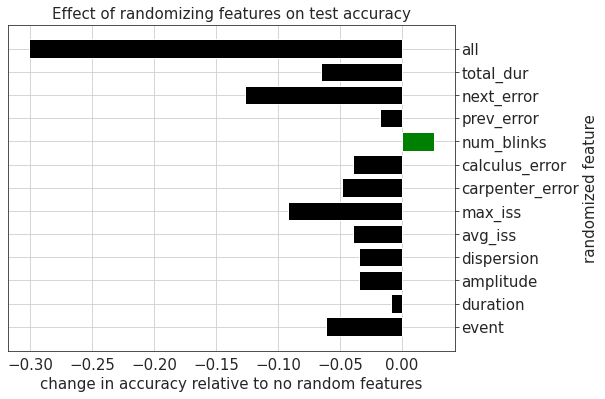

In [45]:
f = plt.figure(figsize=(8,6))
ax = f.add_subplot(111)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
colormap=np.where(FI[FI.rand_feat!='none'].importance>0,'g','black')
plt.barh(FI[FI.rand_feat!='none'].rand_feat,FI[FI.rand_feat!='none'].importance,color=colormap)
plt.grid()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Effect of randomizing features on test accuracy',fontsize=15)
plt.xlabel("change in accuracy relative to no random features",fontsize=15)
plt.ylabel('randomized feature',fontsize=15)
plt.show()

<IPython.core.display.Javascript object>


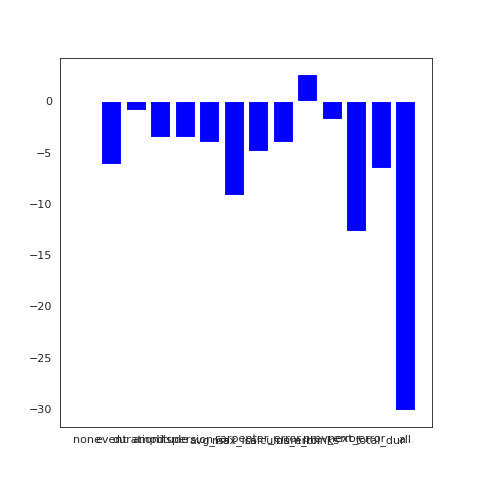

TypeError: vlines() missing 2 required positional arguments: 'ymin' and 'ymax'

In [27]:
plt.figure(figsize=(6,6))
colormap=np.where(FI.rand_feat=='none','orange','blue')
plt.bar(FI.rand_feat,FI.importance*100,color=colormap)
plt.vlines(ground)
plt.yticks()
plt.grid()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Test accuracy',fontsize=15)
plt.xlabel("randomized feature",fontsize=15)
plt.ylabel('% accuracy',fontsize=12)
plt.show()